# Q1: Tri-VAE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copytree('/content/data', '/content/drive/My Drive/hw6')

In [1]:
import kagglehub
import shutil

## Dataset

### downloading datasets

In [2]:
try:
    path = kagglehub.dataset_download("haonanzhou1/ixit2-slices")
    shutil.copytree(path, './data/ixi')
except:
    print("folder already exists!")
shutil.rmtree(path)

100%|██████████| 781M/781M [00:15<00:00, 53.1MB/s]

Extracting files...


In [3]:
try:
    path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
except:
    print("folder already exists!")

100%|██████████| 4.16G/4.16G [00:47<00:00, 93.2MB/s]

Extracting files...


In [4]:
import os
shutil.copytree(os.path.join(path,"BraTS2020_TrainingData"), './data/brats_training/')
shutil.rmtree(path)

### showing a few instances

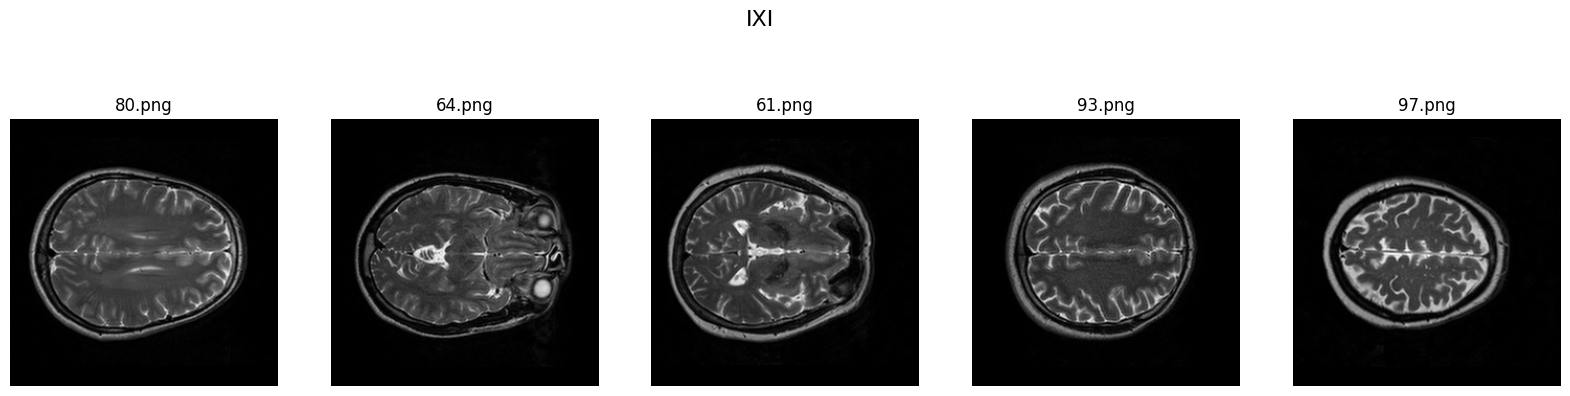

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

dataset_path = '/content/data/ixi/image slice-T2'

image_folders = random.sample(os.listdir(dataset_path), 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('IXI', fontsize=16)

for i, image_folder in enumerate(image_folders):
  image_name = random.sample(os.listdir(os.path.join(dataset_path, image_folder)), 1)[0]
  image_path = os.path.join(dataset_path, image_folder, image_name)
  image = Image.open(image_path)
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(image_name)
  axes[i].axis('off')

plt.show()

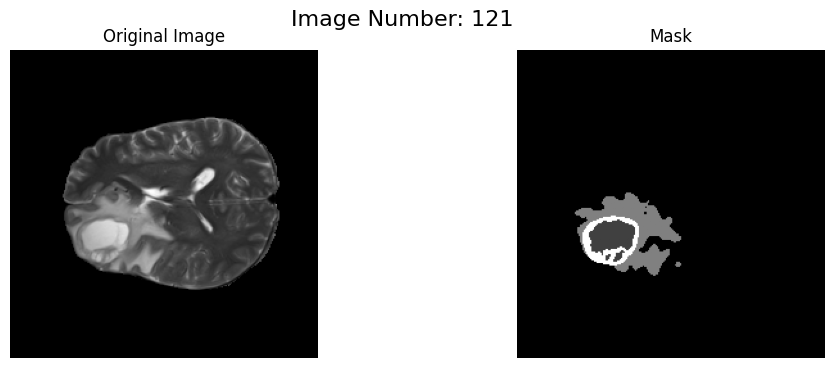

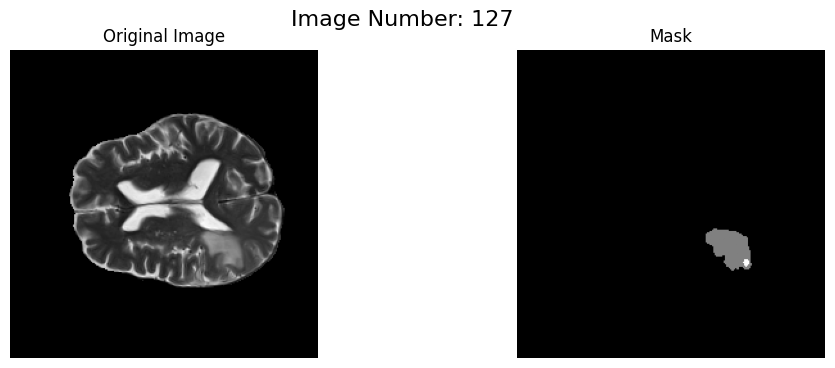

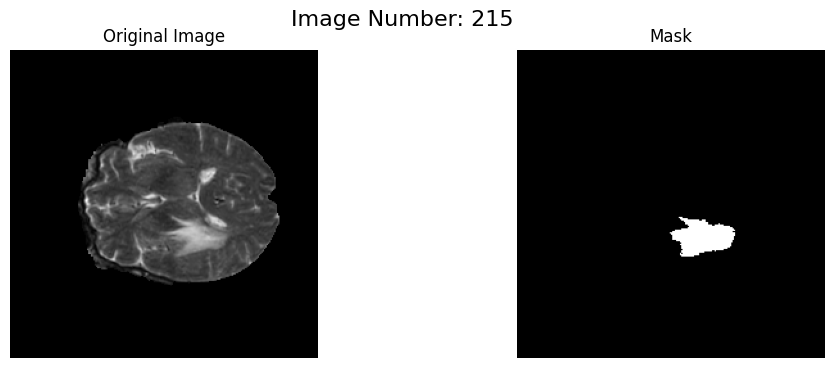

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import random

def show_brats_data(image_addr, image_num):
  image = nib.load(image_addr)
  mask = nib.load(image_addr.replace('_t2', '_seg'))

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  fig.suptitle(f'Image Number: {image_num}', fontsize=16)

  axes[0].imshow(image.get_fdata()[:, :, image.shape[2] // 2], cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  axes[1].imshow(mask.get_fdata()[:, :, mask.shape[2] // 2], cmap='gray')
  axes[1].set_title('Mask')
  axes[1].axis('off')

  plt.show()

brats_folder='/content/data/brats_training/MICCAI_BraTS2020_TrainingData'
img_count=len([item for item in os.listdir(brats_folder) if os.path.isdir(os.path.join(brats_folder, item))])

for i in range(3):
  img_num=random.randint(0, img_count-1)
  img_addr=f'BraTS20_Training_{img_num:03}/BraTS20_Training_{img_num:03}_t2.nii'
  show_brats_data(os.path.join(brats_folder, img_addr), img_num)

### making datasets

In [2]:
from torch.utils.data import Dataset

class IXIDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img = self.df.iloc[idx]['image']

    if self.transform:
      img = self.transform(img)
    return img

class BratsDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img = self.df.iloc[idx]['image']
    mask = self.df.iloc[idx]['mask']

    if self.transform:
      mask = self.transform(mask)
      img = self.transform(img)
    return img, mask

In [3]:
import pandas as pd
import os
from PIL import Image

dataset_path = '/content/data/ixi/image slice-T2'

image_folders = os.listdir(dataset_path)
image_data = []

for i, image_folder in enumerate(image_folders):
  image_names = os.listdir(os.path.join(dataset_path, image_folder))
  for image_name in image_names:
    image_path = os.path.join(dataset_path, image_folder, image_name)
    image = Image.open(image_path)

    image_data.append({'image_path': image_path, 'image': image})
ixi_df = pd.DataFrame(image_data)

In [ ]:
len(ixi_df)

In [4]:
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

brats_folder='/content/data/brats_training/MICCAI_BraTS2020_TrainingData'
brats_folders = [item for item in os.listdir(brats_folder) if os.path.isdir(os.path.join(brats_folder, item))]

brats_data = []

for i, brats_folder_name in enumerate(brats_folders):

  image_addr = os.path.join(brats_folder, brats_folder_name, f'{brats_folder_name}_t2.nii')
  mask_addr = image_addr.replace('_t2', '_seg')
  image = nib.load(image_addr)
  image = image.get_fdata()[:, :, image.shape[2] // 2]

  try:
    mask = nib.load(mask_addr)
  except:
    continue

  mask =  mask.get_fdata()[:, :, mask.shape[2] // 2]

  image = Image.fromarray(image)
  image = np.array(image.resize((256,256)))
  mask = Image.fromarray(mask)
  mask = np.array(mask.resize((256,256)))

  brats_data.append({'image_path': image_addr, 'mask_path': mask_addr, 'image': image, 'mask':mask})

brats_df = pd.DataFrame(brats_data)

In [ ]:
len(brats_data)

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

ixi_dataset = IXIDataset(ixi_df, transform=transform)
brats_dataset = BratsDataset(brats_df, transform=transform)

In [ ]:
small_ixi=IXIDataset(ixi_df[:100], transform=transform)

In [6]:
from torch.utils.data import DataLoader

test_loader=DataLoader(brats_dataset, batch_size=4, shuffle=True)

In [7]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(256*256, 1024)
    self.fc21 = nn.Linear(1024, 20)
    self.fc22 = nn.Linear(1024, 20)
    self.fc3 = nn.Linear(20, 1024)
    self.fc4 = nn.Linear(1024, 256*256)

  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h3 = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))

  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, 256*256))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [ ]:
transform = transforms.ToTensor()
train_loader = DataLoader(small_ixi, batch_size=4, shuffle=True)

vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train(epoch):
  vae.train()
  train_loss = 0
  for batch_idx, data in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = vae(data)
    loss = F.binary_cross_entropy(recon_batch, data.view(-1, 256*256), reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = loss + kld
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  print(f'Epoch: {epoch} Loss: {train_loss / len(train_loader.dataset):.4f}')


In [ ]:
for epoch in range(20):
  train(epoch)

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

def dice_coefficient(pred, target):
    smooth = 1.0
    pred_flat = pred.view(-1).float()
    target_flat = target.view(-1).float()
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

vae.eval()
with torch.no_grad():
  for i, data in enumerate(test_loader):
    data, mask = data
    data = data.view(-1, 256*256)
    recon_batch, _, _ = vae(data.to(device))

    fig, axes = plt.subplots(3, data.size(0), figsize=(12, 9))
    dice_scores = []
    for j in range(data.size(0)):
      original_image = data[j].view(256, 256)
      reconstructed_image = recon_batch[j].view(256, 256)
      mask_image = mask[j].view(256, 256)
      dice_score = dice_coefficient(reconstructed_image.to(device), mask_image.to(device))
      dice_scores.append(dice_score.item())

      axes[0, j].imshow(original_image, cmap='gray')
      axes[0, j].set_title('Original')
      axes[0, j].axis('off')

      axes[1, j].imshow(reconstructed_image.cpu(), cmap='gray')
      axes[1, j].set_title('Reconstructed')
      axes[1, j].axis('off')

      axes[2, j].imshow(mask_image, cmap='gray')
      axes[2, j].set_title(f'Mask\nDice: {dice_score:.4f}')
      axes[2, j].axis('off')

    print(f"Avg Dice: {sum(dice_scores)/len(data)}")

    plt.show()
    break


## TriVAE

In [12]:
pip install pytorch-msssim

In [37]:
import torch.nn as nn
import torch

class Encoder(nn.Module):
    def __init__(self, input_channels=1, latent_dim=128):
        super(Encoder, self).__init__()
        self.conv1_1 = nn.Conv2d(input_channels, 16, 3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.swish = nn.SiLU()
        self.group_norm1 = nn.GroupNorm(16, 16)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.group_norm2 = nn.GroupNorm(32, 32)

        self.conv3_1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.group_norm3 = nn.GroupNorm(64, 64)

        self.conv4_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.group_norm4 = nn.GroupNorm(128, 128)

        self.conv5_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.group_norm5 = nn.GroupNorm(256, 256)

        self.conv6_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv6_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.group_norm6 = nn.GroupNorm(256, 256)

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

    def forward(self, x):
        x = self.group_norm1(self.swish(self.conv1_1(x)))
        x = self.group_norm1(self.swish(self.conv1_2(x)))
        skip_connection1 = x
        x = self.avg_pool(x)

        x = self.group_norm2(self.swish(self.conv2_1(x)))
        x = self.group_norm2(self.swish(self.conv2_2(x)))
        skip_connection2 = x
        x = self.avg_pool(x)

        x = self.group_norm3(self.swish(self.conv3_1(x)))
        x = self.group_norm3(self.swish(self.conv3_2(x)))
        skip_connection3 = x
        x = self.avg_pool(x)

        x = self.group_norm4(self.swish(self.conv4_1(x)))
        x = self.group_norm4(self.swish(self.conv4_2(x)))
        x = self.avg_pool(x)

        x = self.group_norm5(self.swish(self.conv5_1(x)))
        x = self.group_norm5(self.swish(self.conv5_2(x)))
        x = self.avg_pool(x)

        x = self.group_norm6(self.swish(self.conv6_1(x)))
        x = self.group_norm6(self.swish(self.conv6_2(x)))

        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar, skip_connection1, skip_connection2, skip_connection3, x

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class GatedCrossSkip(nn.Module):
    def __init__(self, channels, reduction_ratio=4):
        super(GatedCrossSkip, self).__init__()
        self.conv_e = nn.Conv2d(channels, channels, 1)
        self.conv_d = nn.Conv2d(channels, channels, 1)

        self.encoder_fc = nn.Linear(channels, channels // reduction_ratio)
        self.decoder_fc = nn.Linear(channels, channels // reduction_ratio)


        self.tanh = nn.Tanh()

    def forward(self, encoder_features, decoder_features):
        encoder_proj = self.conv_e(encoder_features)
        decoder_proj = self.conv_d(decoder_features)
        encoder_proj = self.encoder_fc(encoder_proj.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        decoder_proj = self.decoder_fc(decoder_proj.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

        attention_map = F.cosine_similarity(encoder_proj, decoder_proj, dim=1, eps=1e-6)
        modulated_features = self.tanh(attention_map).unsqueeze(1) * decoder_features
        return modulated_features

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, output_channels=1):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim + 256 * 8 * 8, 256 * 8 * 8)
        self.upconv0 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.swish = nn.SiLU()

        self.deconv1_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.deconv1_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.deconv1_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.group_norm1 = nn.GroupNorm(256, 256)
        self.upconv1 = nn.ConvTranspose2d(256, 256, 2, stride=2)

        self.deconv2_1 = nn.Conv2d(256, 128, 3, stride=1, padding=1)
        self.deconv2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.group_norm2 = nn.GroupNorm(128, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.deconv3_1 = nn.Conv2d(128, 64, 3, stride=1, padding=1)
        self.deconv3_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.group_norm3 = nn.GroupNorm(64, 64)
        self.upconv3 = nn.ConvTranspose2d(64, 32, 2, stride=2)

        self.deconv4_1 = nn.Conv2d(64, 32, 3, stride=1, padding=1)
        self.deconv4_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.group_norm4 = nn.GroupNorm(32, 32)
        self.upconv4 = nn.ConvTranspose2d(32, 16, 2, stride=2)

        self.deconv5_1 = nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.deconv5_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.deconv5_3 = nn.Conv2d(16, 1, 3, stride=1, padding=1)
        self.group_norm5 = nn.GroupNorm(16, 16)
        # self.upconv5 = nn.ConvTranspose2d(16, 1, 2, stride=2)

        self.coarse_conv1 = nn.Conv2d(128, 64, 3, stride=1, padding=1)
        self.coarse_conv2 = nn.Conv2d(64, 32, 3, stride=1, padding=1)
        self.coarse_conv3 = nn.Conv2d(32, 1, 1)

        self.gcs = GatedCrossSkip(64)

    def forward(self, z, skip_connection1, skip_connection2, skip_connection3):
        z = self.swish(self.fc(z)).view(-1, 256, 8, 8)
        z = self.upconv0(z)

        z = self.group_norm1(self.swish(self.deconv1_1(z)))
        z = self.group_norm1(self.swish(self.deconv1_2(z)))
        z = self.group_norm1(self.swish(self.deconv1_3(z)))
        z = self.upconv1(z)

        z = self.group_norm2(self.swish(self.deconv2_1(z)))
        z = self.group_norm2(self.swish(self.deconv2_2(z)))
        x_coarse = self.group_norm3(self.swish(self.coarse_conv1(z)))
        x_coarse = self.group_norm4(self.swish(self.coarse_conv2(x_coarse)))
        x_coarse = self.swish(self.coarse_conv3(x_coarse))
        z = self.upconv2(z)

        gcs_out=self.gcs(skip_connection3, z)
        z=torch.cat((gcs_out, z), dim=1)

        # z=torch.cat((skip_connection3, z), dim=1)
        z = self.group_norm3(self.swish(self.deconv3_1(z)))
        z = self.group_norm3(self.swish(self.deconv3_2(z)))
        z = self.upconv3(z)

        z=torch.cat((skip_connection2, z), dim=1)
        z = self.group_norm4(self.swish(self.deconv4_1(z)))
        z = self.group_norm4(self.swish(self.deconv4_2(z)))
        z = self.upconv4(z)

        z=torch.cat((skip_connection1, z), dim=1)
        z = self.group_norm5(self.swish(self.deconv5_1(z)))
        z = self.group_norm5(self.swish(self.deconv5_2(z)))
        z = self.swish(self.deconv5_3(z))
        # z = self.upconv5(z)

        return z, x_coarse

In [39]:
class TriVAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=128):
        super(TriVAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)

    def forward(self, x, encoder_features=None):
        mu, logvar, e1, e2, e3, e_output = self.encoder(x)
        # z = torch.cat((mu, e_output.view(e_output.size(0), -1)), dim=1)
        z = torch.cat((self.sample(mu, logvar), e_output), dim=1)

        x_hat, x_coarse = self.decoder(z, e1, e2, e3)
        return x_hat, x_coarse, mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


In [51]:
import torch
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.optim import Adam
from skimage.metrics import structural_similarity as ssim
from pytorch_msssim import ssim
import torch.nn as nn
import torch

transform = transforms.ToTensor()
# train_loader = DataLoader(small_ixi, batch_size=4, shuffle=True)
ixi1000_dataset = IXIDataset(ixi_df[:1000], transform=transform)
train_loader = DataLoader(ixi1000_dataset, batch_size=8, shuffle=True)

trivae = TriVAE(input_channels=1, latent_dim=512).to(device)

optimizer = Adam(trivae.parameters(), lr=1e-3)

def triplet_loss(anchor, positive, negative, alpha=1.0):
    pos_dist = F.pairwise_distance(anchor, positive, p=2)
    neg_dist = F.pairwise_distance(anchor, negative, p=2)
    loss = torch.clamp(pos_dist - neg_dist + alpha, min=0.0).sum()
    return loss


def train_trivae(epoch):
    trivae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        anchor = data.to(device)
        positive = data.to(device)
        negative = data.to(device)
        noise = torch.randn_like(negative)
        negative += noise*100
        # negative /= 2 ## TODO

        recon_anchor_full, recon_anchor_coarse, mu_anchor, logvar_anchor = trivae(anchor)
        recon_positive_full, recon_positive_coarse, mu_positive, logvar_positive = trivae(positive)
        recon_negative_full, recon_negative_coarse, mu_negative, logvar_negative = trivae(negative)

        negative_resized = transforms.Resize((recon_negative_coarse.shape[2], recon_negative_coarse.shape[3]))(negative)
        positive_resized = transforms.Resize((recon_positive_coarse.shape[2], recon_positive_coarse.shape[3]))(positive)
        anchor_resized = transforms.Resize((recon_anchor_coarse.shape[2], recon_anchor_coarse.shape[3]))(anchor)
        l1_neg_coarse = F.l1_loss(recon_negative_coarse, negative_resized)
        l1_neg_full = F.l1_loss(recon_negative_full, negative)
        l1_anc = F.l1_loss(recon_anchor_coarse, anchor_resized)
        l1_pos = F.l1_loss(recon_positive_coarse, positive_resized)
        l1_total= l1_neg_coarse + l1_neg_full + l1_anc + l1_pos

        kld_anc = -0.5 * (1 + logvar_anchor - mu_anchor.pow(2) - logvar_anchor.exp()).mean()
        kld_pos = -0.5 * (1 + logvar_positive - mu_positive.pow(2) - logvar_positive.exp()).mean()
        kld = kld_anc + kld_pos

        triplet = triplet_loss(mu_anchor, mu_positive, mu_negative, alpha=1.0)

        ssim_loss = (1 - ssim(recon_negative_full, negative))*10
        # loss = l1_total# ssim_loss
        loss = l1_total/10 + kld + triplet + ssim_loss
        # print(l1_total /10, kld, triplet, ssim_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch: {epoch} Loss: {train_loss / len(train_loader.dataset):.4f}")

# train_trivae(-1)

In [164]:
ixi_df.size

57700

In [ ]:
for epoch in range(20):
  train_trivae(epoch)

In [198]:
torch.cuda.empty_cache()
# trivae.to("cpu")

torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 32, 32])


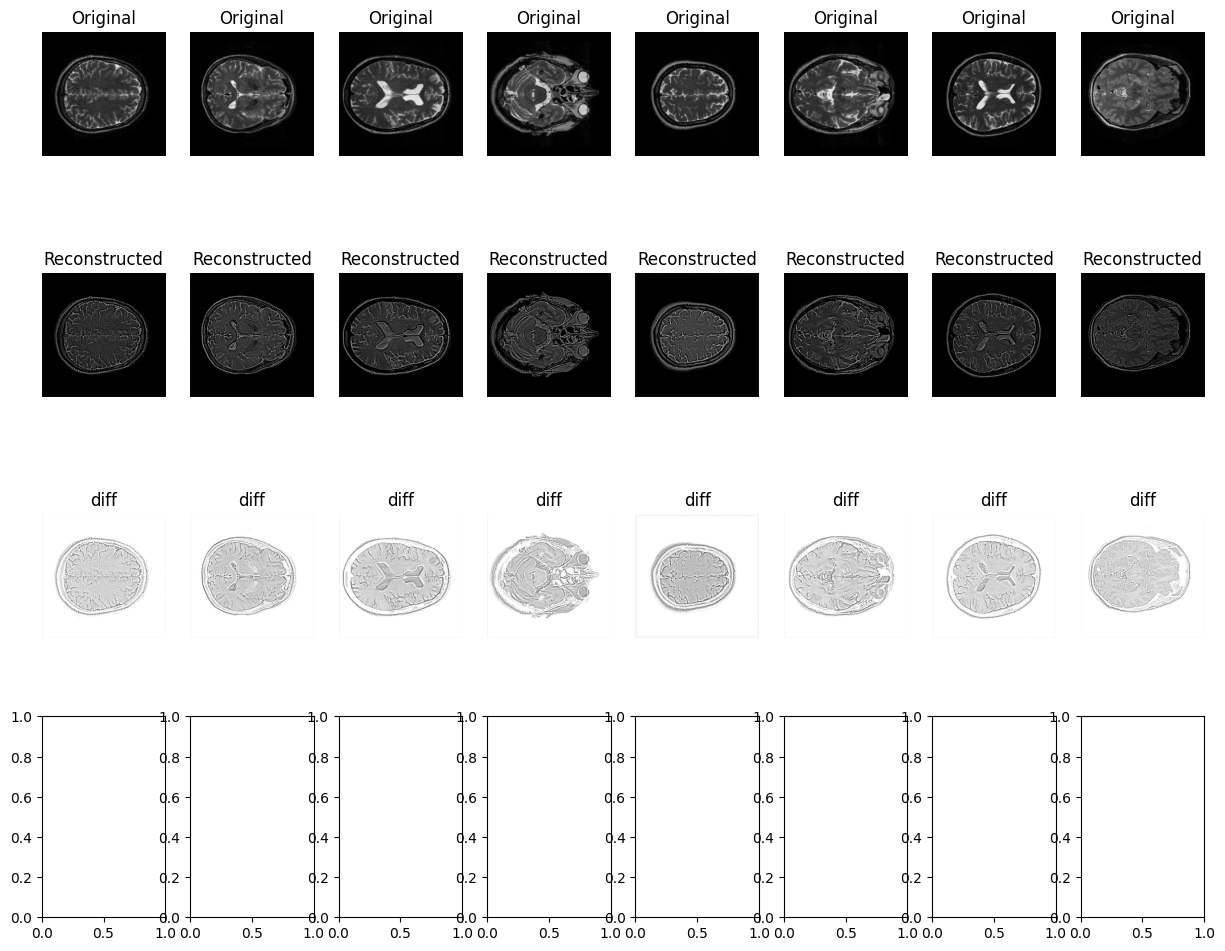

In [43]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

trivae.eval()
with torch.no_grad():
    for i, (data) in enumerate(train_loader):
        data = data.to(device)#, mask.to(device)
        recon_batch, recon2_batch, _, _ = trivae(data.to(device))
        print(recon_batch.shape, recon2_batch.shape)
        fig, axes = plt.subplots(4, data.size(0), figsize=(15, 12))
        dice_scores = []
        for j in range(data.size(0)):
            original_image = data[j].cpu().view(256, 256)

            ########################################
            reconstructed_image = recon_batch[j].cpu().view(256, 256)
            # mask_image = mask[j].cpu().view(256, 256)

            axes[0, j].imshow(original_image, cmap='gray')
            axes[0, j].set_title('Original')
            axes[0, j].axis('off')

            axes[1, j].imshow(reconstructed_image, cmap='gray')
            axes[1, j].set_title('Reconstructed')
            axes[1, j].axis('off')

            axes[2, j].imshow(original_image-reconstructed_image, cmap='gray')
            axes[2, j].set_title('diff')
            axes[2, j].axis('off')

        plt.show()
        break

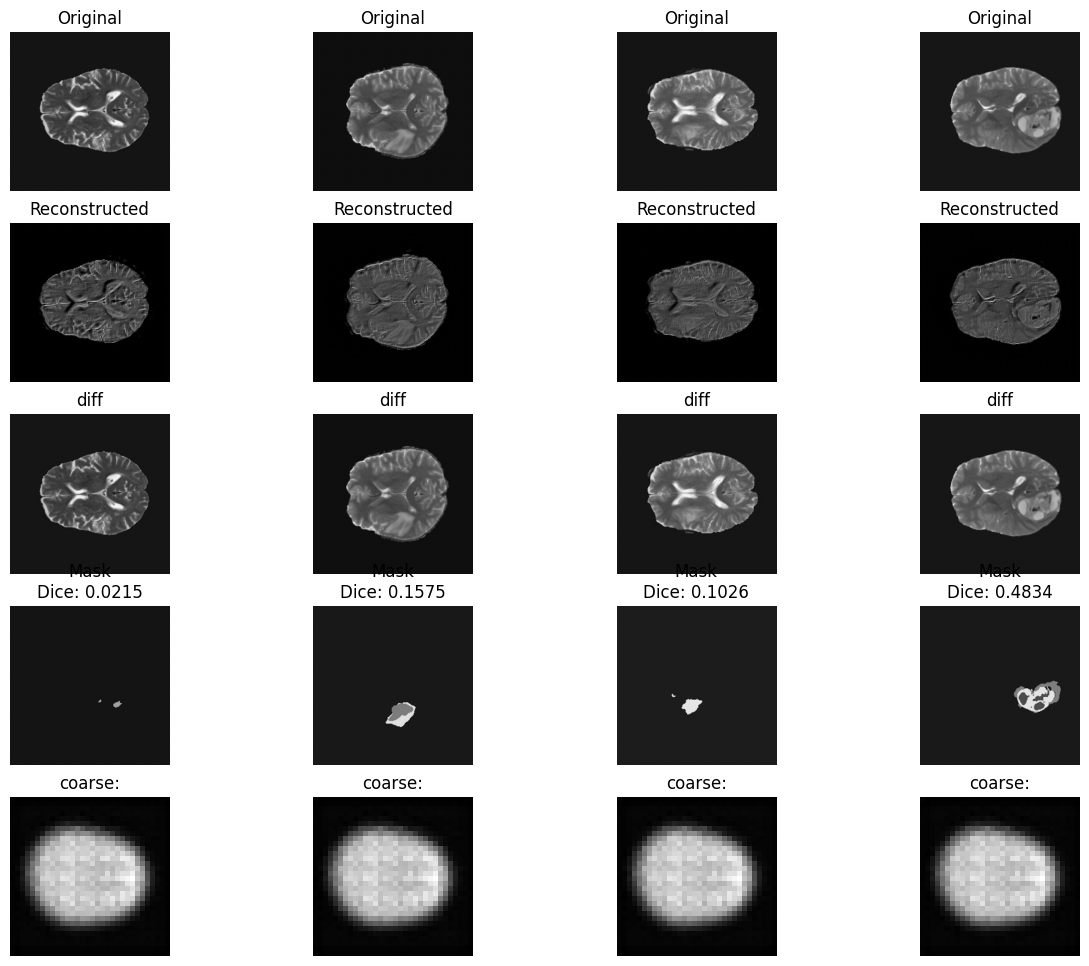

In [50]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def dice_coefficient(pred, target, threshold=0.5):
    smooth = 1.0
    pred_flat = (pred > threshold).float().view(-1)
    target_flat = target.view(-1).float()
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

trivae.eval()
with torch.no_grad():
    # for i, data in enumerate(train_loader):
    for i, (data, mask) in enumerate(test_loader):
        #data, mask = data.to(device), mask.to(device)
        recon_batch, recon2_batch, _, _ = trivae(data.to(device))
        # print(recon_batch.shape, recon2_batch.shape)
        fig, axes = plt.subplots(5, data.size(0), figsize=(15, 12))
        dice_scores = []
        for j in range(data.size(0)):
            original_image = data[j].cpu().view(256, 256)

            ########################################
            reconstructed_image = recon_batch[j].cpu().view(256, 256)
            mask_image = mask[j].cpu().view(256, 256)

            coarse = recon2_batch[j].cpu().view(32, 32)

            dice_score = dice_coefficient(original_image-reconstructed_image, mask_image)
            dice_scores.append(dice_score.item())
            # print(original_image//10000)
            # print(reconstructed_image/1000000)

            axes[0, j].imshow(original_image, cmap='gray')
            axes[0, j].set_title('Original')
            axes[0, j].axis('off')

            axes[1, j].imshow(reconstructed_image, cmap='gray')
            axes[1, j].set_title('Reconstructed')
            axes[1, j].axis('off')

            axes[2, j].imshow(original_image-reconstructed_image, cmap='gray')
            axes[2, j].set_title('diff')
            axes[2, j].axis('off')

            axes[3, j].imshow(mask_image, cmap='gray')
            axes[3, j].set_title(f'Mask\nDice: {dice_score:.4f}')
            axes[3, j].axis('off')

            axes[4, j].imshow(coarse, cmap='gray')
            axes[4, j].set_title(f'coarse:')
            axes[4, j].axis('off')

        # avg_dice = sum(dice_scores) / len(dice_scores)
        # print(f"Avg Dice: {avg_dice:.4f}")

        plt.show()
        break